In [3]:
from fastai.tabular import *
from fastai.basics import *

# rossman 

## get data 

In [5]:
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [6]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


### sample: what does fastai procs do? 

In [9]:
n = train_df.shape[0]; n

844338

In [10]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [11]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
35,36,5,"Jan,Apr,Jul,Oct",540.0,50,12422
1925,814,4,NaN,24530.0,58,10220
2148,1038,4,NaN,17290.0,59,6901
2547,323,3,"Feb,May,Aug,Nov",8400.0,63,8059
2769,545,3,"Feb,May,Aug,Nov",5020.0,67,12181


Categorify changes categorical variable to numerical codes

In [12]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

For example, PromoInterval has 3 unique values and NaN

In [13]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [18]:
small_train_df.PromoInterval.nunique()

3

fastai then encode those 3 unique values with 0,1,2 and the NaN value with -1

In [17]:
set(small_train_df['PromoInterval'].cat.codes.values)

{-1, 0, 1, 2}

FillMissing replaces the missing values with, by default, the median value. FillMissing also creates an isNaN column for each feature to keep track of the missing values and also in case the missing-ness can actually be informative and interact with other features.

In [19]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [20]:
small_train_df[small_train_df['CompetitionDistance_na']]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
75258,879,2,"Feb,May,Aug,Nov",2085.0,61,2662,True
128511,291,5,NaN,2085.0,89,6614,True


## main

In [7]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [8]:
train_df.shape, test_df.shape

((844338, 93), (41088, 92))

In [21]:
procs = [FillMissing, Categorify, Normalize]

As per usual, for tabular, we need to define the categorical and numerical features.

In [23]:

cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

And the dependend variable:

In [24]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var, 'Date']].copy()

In [25]:
test_df['Date'].min(), test_df['Date'].max() 

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [30]:
train_df['Date'].head()

0   2015-07-31
1   2015-07-31
2   2015-07-31
3   2015-07-31
4   2015-07-31
Name: Date, dtype: datetime64[ns]

In [31]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [32]:
valid_idx = range(cut)

We define the data block as per usual. Note that we set label_from_df(.. label_cls = FloatList..), because the dependent variable is of type int. Fastai, upon seeing this, will automatically think it's a classification problem as opposed to a regression problem with float values. Thus, we have to specify the labels are float. In addition, Jeremy takes the logarithm of the dependent var (log=True), apparently this is standard practice. 

In [33]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

###  modelling

We are using the y_range trick again.

In [34]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [35]:
y_range

tensor([ 0.0000, 10.8170], device='cuda:0')

In [36]:
learn = tabular_learner(data, layers=[1000,500]
                        , ps=[0.001,0.01] # drop out
                        , emb_drop=0.04, # embedding drop out
                        y_range=y_range, metrics=exp_rmspe)

ok, embedding size...

In [38]:
learn.model.embeds

ModuleList(
  (0): Embedding(1116, 81)
  (1): Embedding(8, 5)
  (2): Embedding(4, 3)
  (3): Embedding(13, 7)
  (4): Embedding(32, 11)
  (5): Embedding(3, 3)
  (6): Embedding(26, 10)
  (7): Embedding(27, 10)
  (8): Embedding(5, 4)
  (9): Embedding(4, 3)
  (10): Embedding(4, 3)
  (11): Embedding(24, 9)
  (12): Embedding(9, 5)
  (13): Embedding(13, 7)
  (14): Embedding(53, 15)
  (15): Embedding(22, 9)
  (16): Embedding(7, 5)
  (17): Embedding(7, 5)
  (18): Embedding(4, 3)
  (19): Embedding(4, 3)
  (20): Embedding(9, 5)
  (21): Embedding(9, 5)
  (22): Embedding(3, 3)
  (23): Embedding(3, 3)
)

### training

In [39]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


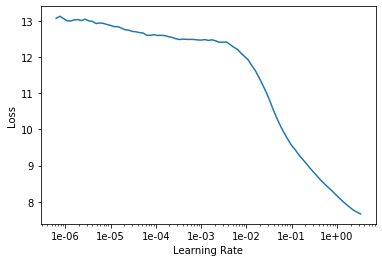

In [40]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(4, 1e-1, wd=.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,4.440320,4.371500,8.157583,07:20
1,4.643042,4.437510,8.154929,07:15
2,0.067761,0.066301,0.228467,07:02
3,0.015842,0.015919,0.120282,07:08


epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


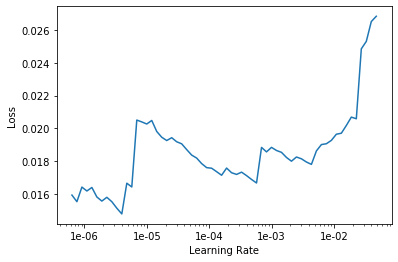

In [42]:
learn.lr_find(); learn.recorder.plot()

In [44]:
learn.save('1')

In [45]:
learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.015704,0.015735,0.119624,07:00
1,0.014144,0.016183,0.114710,07:08
2,0.013836,0.014674,0.111289,07:12
3,0.014467,0.013837,0.115326,07:26


10th place in the original Rossmann competition is about 0.108